In [47]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorspacious import cspace_converter
from matplotlib.pyplot import rc_context
from matplotlib import colormaps
import scipy
import scipy.stats as stats
import matplotlib.ticker as ticker
import json
from openpyxl import Workbook
import seaborn as sns
from adjustText import adjust_text


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/ubuntu/anaconda3/envs/scanpyenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.5 pynndescent==0.5.12


In [3]:
adata_uninfected_subset = sc.read_h5ad('/vol/ExtraVol/DataHistory/Parasite_Clustered_UninfectedSubset.h5ad')

In [4]:
# Load the marker genes dictionary from the JSON file
with open('/vol/ExtraVol/ParasiteDEX/marker_genes_dict.json', 'r') as f:
    marker_genes_dict = json.load(f)

In [5]:
genelist =['Pdpn', 'Pdgfra', 'Igfbp3', 'Fgfr2', 'Pdgfrb', 'Des', 'Acta2', 'Myh11', 'Actg2', 'Cd81', 'Ackr4', 'Cd55', 'Cd34', 'Jam2', 'Ccl11', 'Kit', 'Hand1']

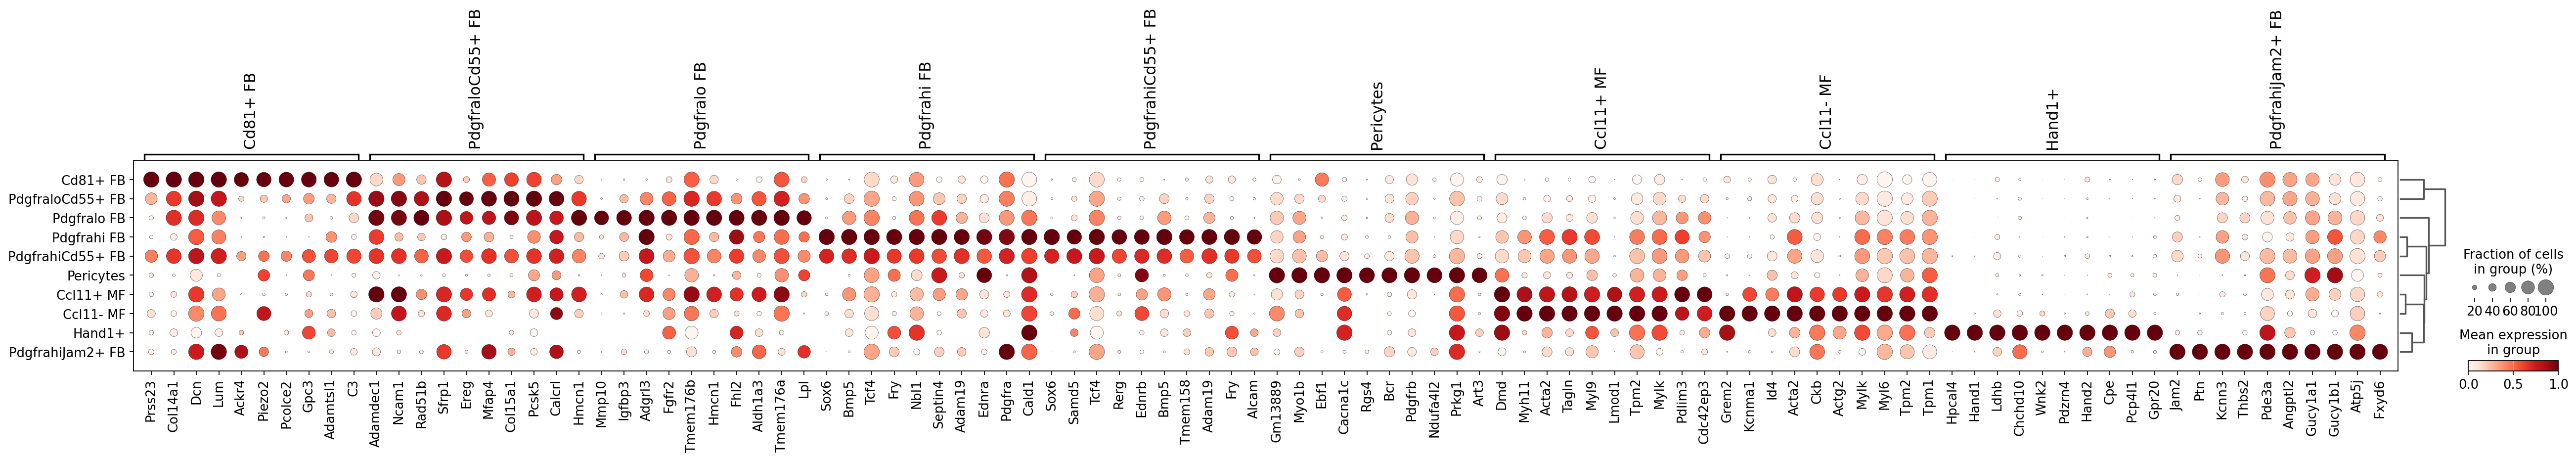

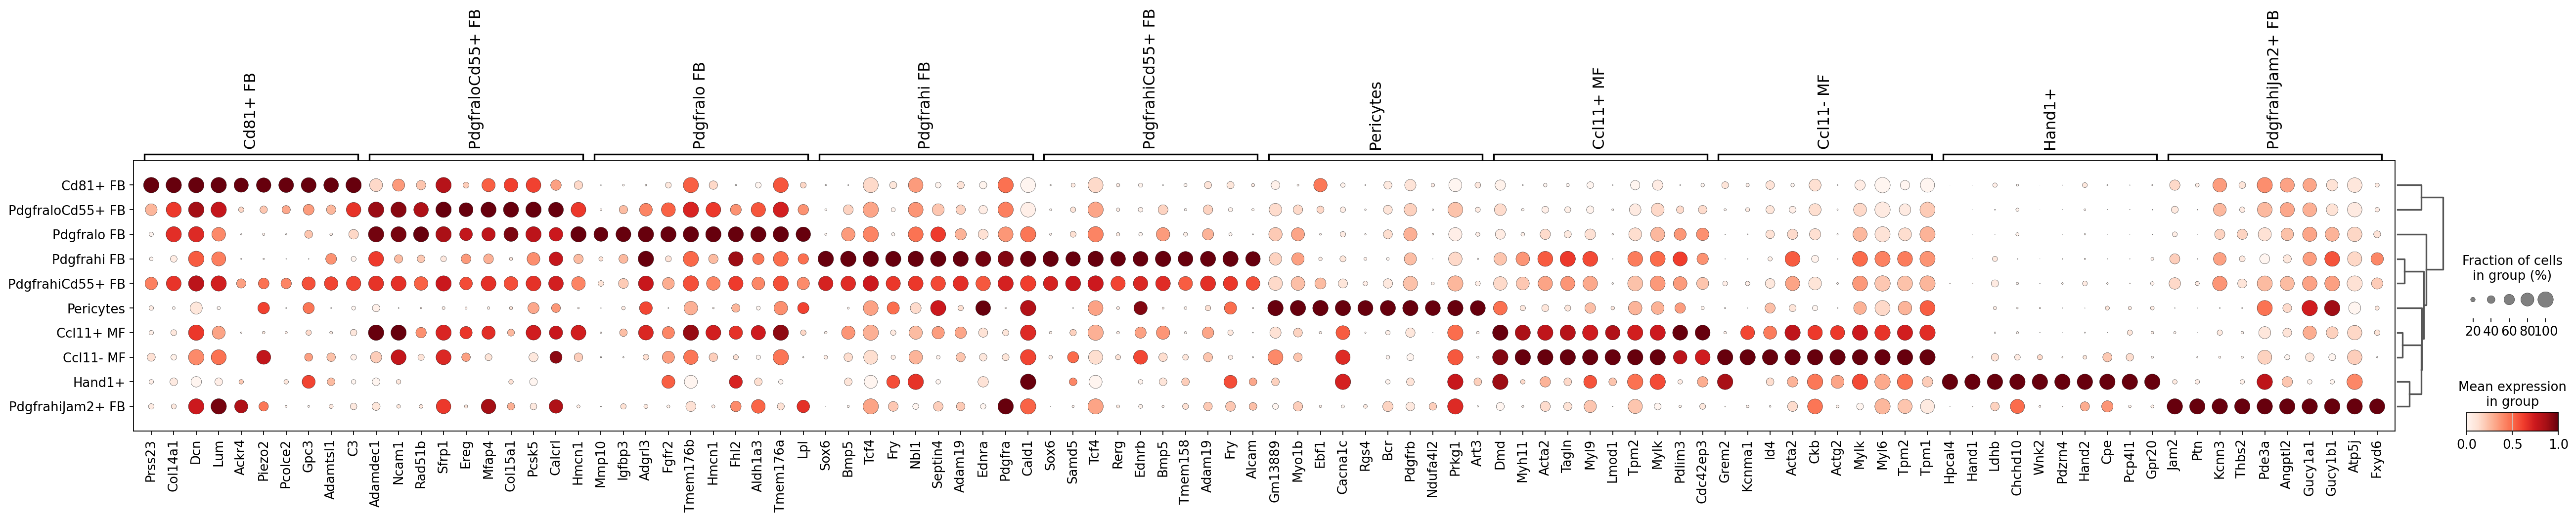

In [6]:
ax = sc.pl.dotplot(adata_uninfected_subset, marker_genes_dict, groupby='identity', dendrogram=True, dot_max=1, dot_min=0, standard_scale='var', return_fig=True)
# Save the plot as a PDF
ax.savefig('/vol/ExtraVol/ParasiteDEX/marker_genes_dotplot.pdf')
# Show the plot (optional)
ax.show()

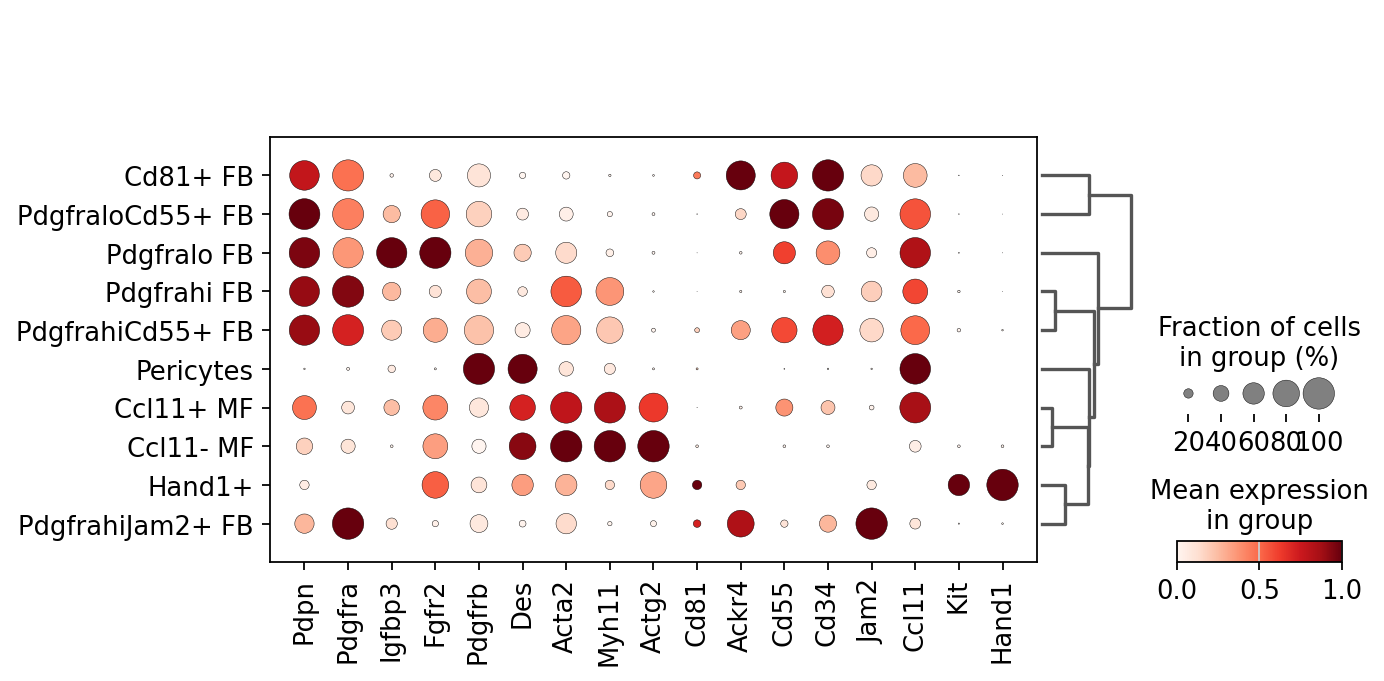

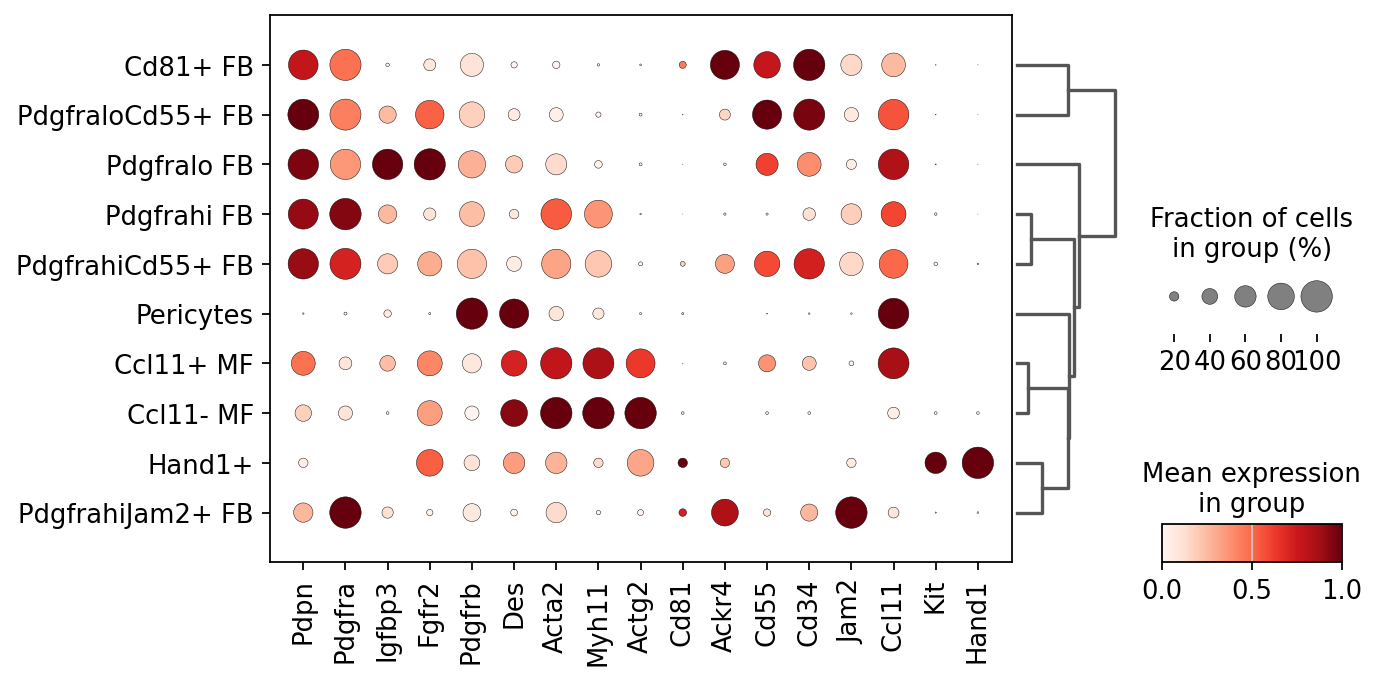

In [7]:
ax = sc.pl.dotplot(adata_uninfected_subset, genelist, groupby='identity', dendrogram=True, dot_max=1, dot_min=0, standard_scale='var', return_fig=True)
# Save the plot as a PDF
ax.savefig('/vol/ExtraVol/ParasiteDEX/genelist_dotplot.pdf')
# Show the plot (optional)
ax.show()

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_identity']`


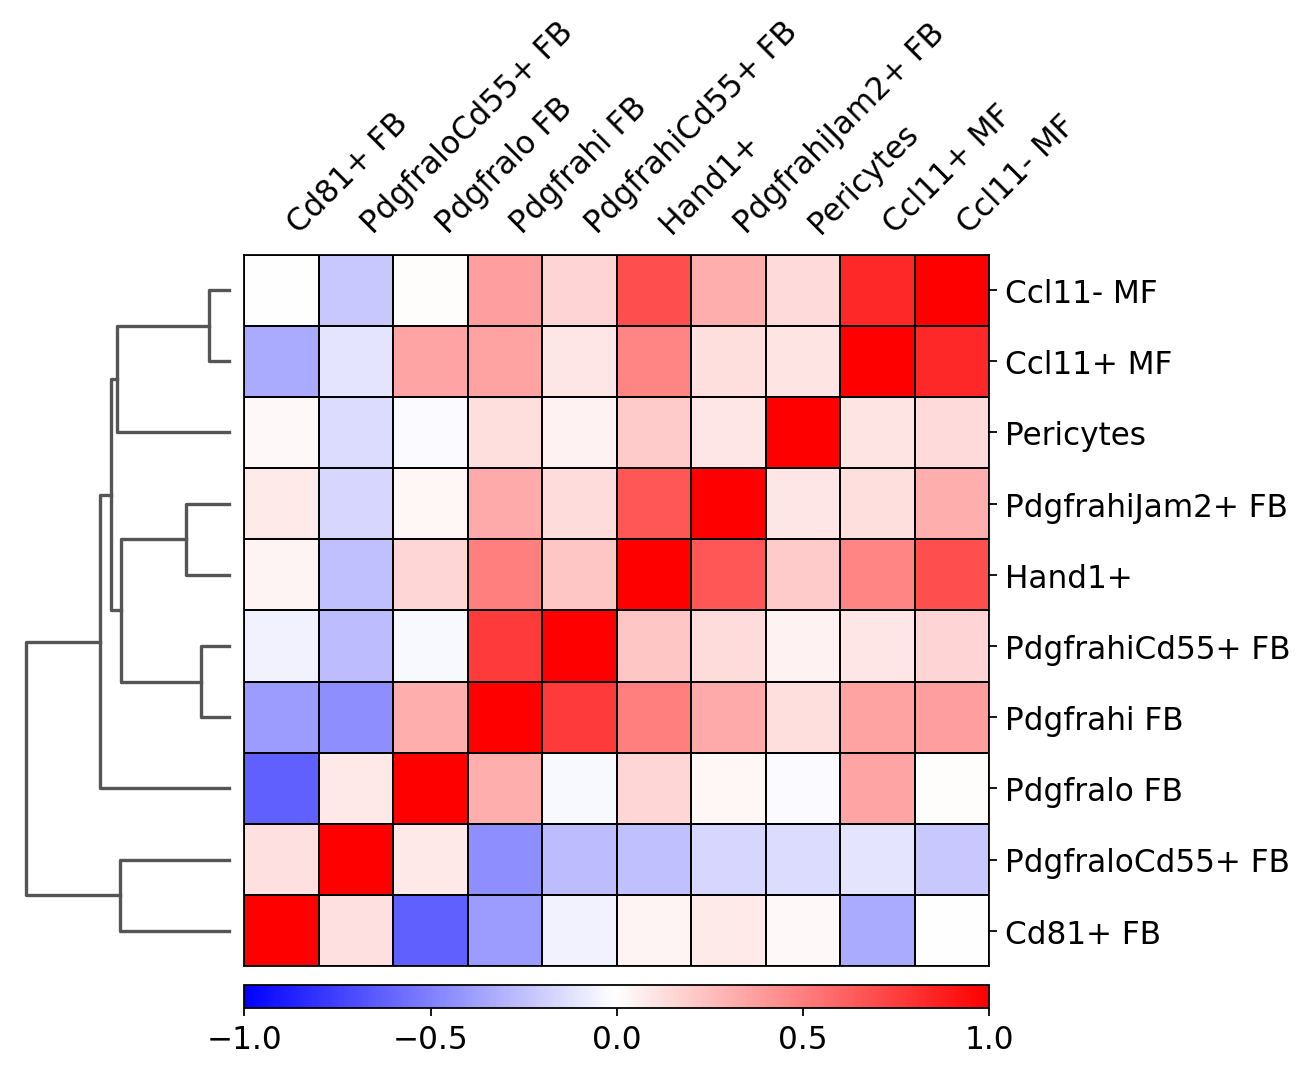

<Figure size 320x320 with 0 Axes>

In [8]:
sc.tl.dendrogram(adata_uninfected_subset, 'identity', n_pcs=30)

# Temporarily set rcParams to remove gridlines
with plt.rc_context({'axes.grid': False}):
    sc.pl.correlation_matrix(adata_uninfected_subset, 'identity')
    # Save the plot as a PDF
    plt.savefig('/vol/ExtraVol/ParasiteDEX/correlation_matrix.pdf')
    # Show the plot (optional)
    plt.show()

In [9]:
adata = sc.read_h5ad('/vol/ExtraVol/DataHistory/Parasite_Clustered.h5ad')

/home/ubuntu/anaconda3/envs/scanpyenv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


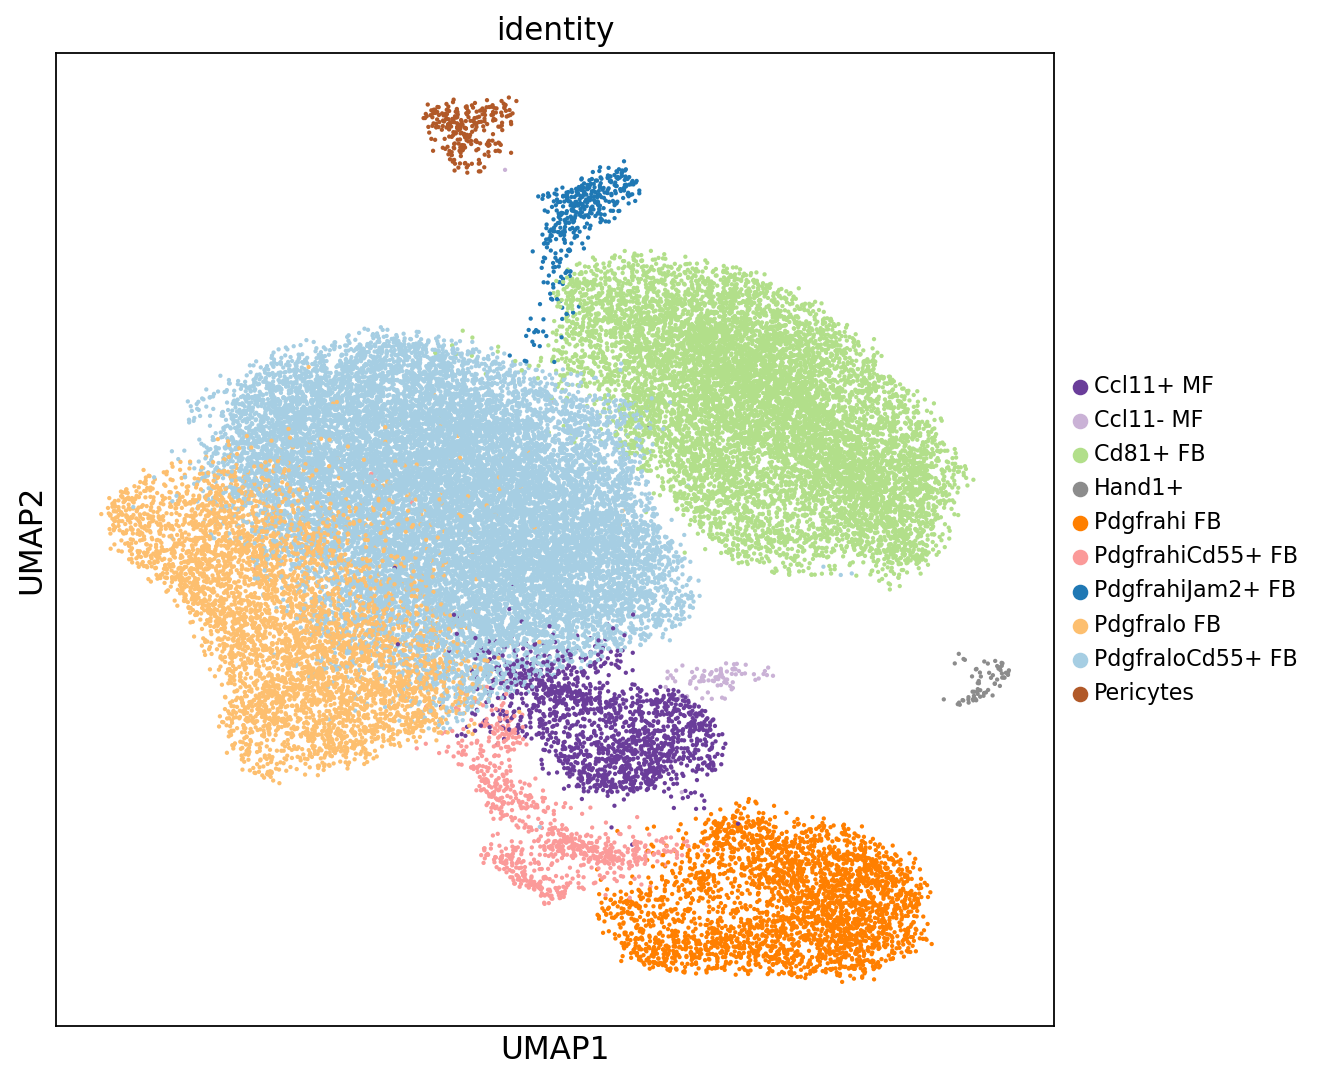

In [10]:
colors_hex = {
    "PdgfraloCd55+ FB": "#a6cee3",
    "Cd81+ FB": "#b2df8a",
    "Pdgfralo FB": "#fdbf6f",
    "Pdgfrahi FB": "#ff7f00",
    "Ccl11+ MF": "#6a3d9a",
    "PdgfrahiCd55+ FB": "#fb9a99",
    "PdgfrahiJam2+ FB": "#1f78b4",
    "Pericytes": "#b15928",
    "Ccl11- MF": "#CAB2D6",
    "Hand1+": "#8c8c8c"
}
sc.tl.umap(adata, init_pos='paga', min_dist=0.5, spread=0.5)
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color = "identity", use_raw=False, legend_fontsize = 10, na_in_legend = False, size=15, palette = colors_hex)

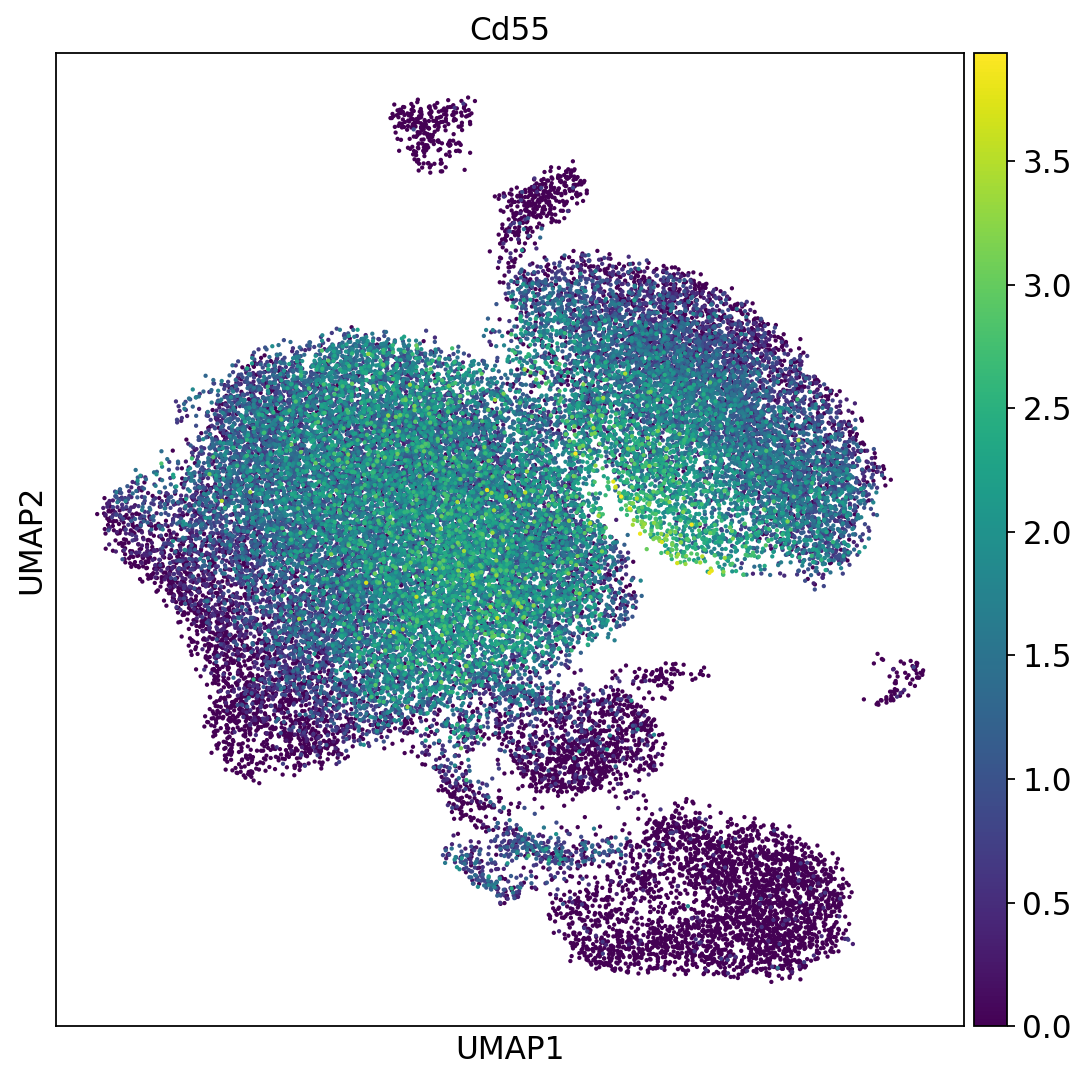

In [70]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color = "Cd55", use_raw=False, legend_fontsize = 10, na_in_legend = False, size=15)

In [69]:
# Define the pairs for comparison
pairs = [
    ('PdgfrahiCd55+ FB', 'Pdgfrahi FB'),
    ('PdgfrahiJam2+ FB', 'Pdgfrahi FB'),
    ('PdgfraloCd55+ FB', 'Pdgfralo FB'),
    ('Ccl11+ MF', 'Ccl11- MF')
]

# Create a new workbook
wb = Workbook()
wb.remove(wb.active)  # Remove the default sheet

# Loop over each pair
for group, reference in pairs:
    # Run differential expression analysis
    sc.tl.rank_genes_groups(adata_uninfected_subset, 'identity', method='wilcoxon', 
                            use_raw=False, groups=[group], reference=reference)
    
    # Extract the results into a DataFrame
    df = sc.get.rank_genes_groups_df(adata_uninfected_subset, group=group)
    
    # Calculate signed -log10 adjusted p-value
    df['signedlogpadj'] = np.sign(df['logfoldchanges']) * -np.log10(df['pvals_adj'] + 1e-300)  # Adding a small constant to avoid log(0)
    
    # Sort by the signed -log10 adjusted p-value
    df = df.sort_values('signedlogpadj', ascending=False).reset_index(drop=True)
    
    # Add a rank column
    df['rank'] = df.index
    
    # Create a sheet name without "FB" and "MF"
    sheet_name = group.replace(' FB', '').replace(' MF', '').replace(' ', '') + 'vs' + reference.replace(' FB', '').replace(' MF', '').replace(' ', '')
    
    # Add the DataFrame to a new sheet in the workbook
    ws = wb.create_sheet(title=sheet_name)
    
    # Write the DataFrame to the sheet
    for r_idx, row in enumerate(df.itertuples(), 1):
        for c_idx, value in enumerate(row[1:], 1):  # skip the index in row
            ws.cell(row=r_idx, column=c_idx, value=value)
    
    # Add header
    for col_idx, col_name in enumerate(df.columns, 1):
        ws.cell(row=1, column=col_idx, value=col_name)

# Save the workbook
wb.save('/vol/ExtraVol/ParasiteDEX/ParasiteDEX_SelectedPairs_Results.xlsx')

# Confirm completion
print("Data frames have been exported to Excel workbook successfully.")


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


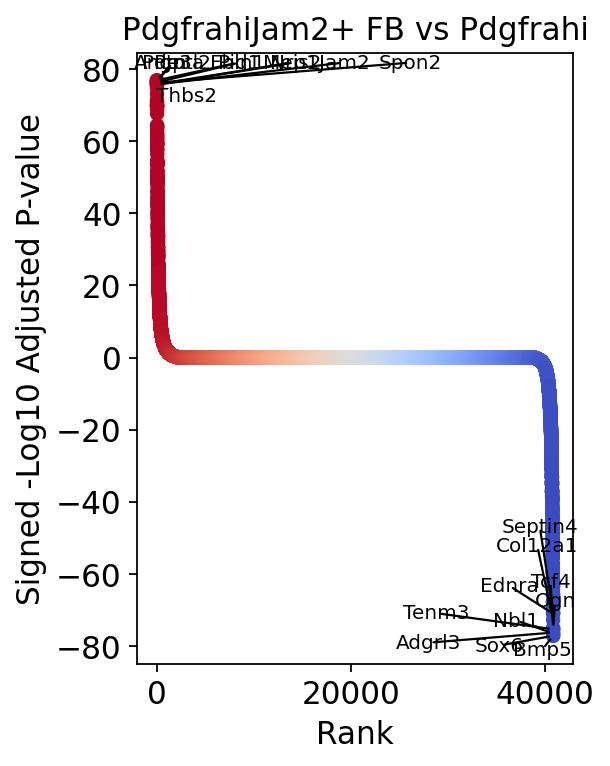

In [67]:
# Run differential expression analysis
sc.tl.rank_genes_groups(adata_uninfected_subset, 'identity', method='wilcoxon', 
                        use_raw=False, groups=['PdgfrahiJam2+ FB'], reference='Pdgfrahi FB')

# Extract the results into a DataFrame
df = sc.get.rank_genes_groups_df(adata_uninfected_subset, group='PdgfrahiJam2+ FB')

# Calculate signed -log10 adjusted p-value
df['signed -log10(padj)'] = np.sign(df['logfoldchanges']) * -np.log10(df['pvals_adj'] + 1e-300)  # Adding a small constant to avoid log(0)

# Sort by the signed -log10 adjusted p-value
df = df.sort_values('signed -log10(padj)', ascending=False).reset_index(drop=True)

# Add a rank column
df['rank'] = df.index + 1

# Create the waterfall plot
plt.figure(figsize=(4, 5))
sns.scatterplot(data=df, x='rank', y='signed -log10(padj)', hue='rank', 
                palette=sns.color_palette("coolwarm_r", as_cmap=True), edgecolor=None, legend=False)

# Add titles and labels
plt.title('PdgfrahiJam2+ FB vs Pdgfrahi')
plt.xlabel('Rank')
plt.ylabel('Signed -Log10 Adjusted P-value')

# Remove grid lines
plt.grid(False)

# Create annotations for the top 10 genes from both ends
annotations = []
for i in list(df.head(10).index):
    annotations.append(plt.text(df.loc[i, 'rank'], df.loc[i, 'signed -log10(padj)'],
                                df.loc[i, 'names'], fontsize=9, ha='right', color='black'))
for i in list(df.tail(10).index):
    annotations.append(plt.text(df.loc[i, 'rank'], df.loc[i, 'signed -log10(padj)'],
                                df.loc[i, 'names'], fontsize=9, ha='left', color='black'))

# Adjust text to avoid overlap
adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='black'), force_text=0.2, expand_text=(1, 1))

# Customize the layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('/vol/ExtraVol/ParasiteDEX/waterfall_plot_Pdgfrahi_vs_PdgfrahiCd55pos.pdf')

# Show the plot
plt.show()


In [41]:
df

names     scores  logfoldchanges         pvals     pvals_adj  \
0         Sox6  19.214134       14.079440  2.818945e-82  6.078477e-78   
1         Bmp5  19.211357        7.933506  2.973887e-82  6.078477e-78   
2         Nbl1  19.077839        5.814013  3.858874e-81  2.858032e-77   
3       Adgrl3  19.025661        6.059544  1.045592e-80  4.749193e-77   
4          Ogn  18.889565        5.190616  1.389882e-79  4.052860e-76   
...        ...        ...             ...           ...           ...   
40874     Pid1 -19.033598       -5.050219  8.986645e-81  4.592063e-77   
40875      Ptn -19.054825       -9.720188  5.991609e-81  3.499014e-77   
40876  Angptl2 -19.073475       -4.781040  4.194866e-81  2.858032e-77   
40877    Pde3a -19.139143       -5.606186  1.192164e-81  1.218362e-77   
40878    Fbln1 -19.154221       -6.376888  8.925224e-82  1.216181e-77   

       signed -log10(padj)   rank  
0                77.216205      1  
1                77.216205      2  
2                76.543933      3  
3                76.323380      4  
4                75.392238      5  
...                    ...    ...  
40874           -76.337992  40875  
40875           -76.456054  40876  
40876           -76.543933  40877  
40877           -76.914224  40878  
40878           -76.915002  40879  

[40879 rows x 7 columns]

In [80]:
adata.obsm

AxisArrays with keys: X_pca, X_umap